In [15]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import os
import utils

from pprint import pprint

In [16]:
# Load all data
tloop_seqs = utils.load('data/tloop_seqs.pickle')
pdb_seqs = utils.load('data/pdb_seqs.pickle')
all_seqs = utils.load('data/all_seqs.pickle')

all_fragments_8 = utils.load('data/all_fragments_8.pickle')
all_fragments_10 = utils.load('data/all_fragments_10.pickle')
all_fragments_12 = utils.load('data/all_fragments_12.pickle')
all_fragments_14 = utils.load('data/all_fragments_14.pickle')

# Fragments

## Unique fragments
The number of unique RNA fragments is $4^{8} = 65536$. The theoretical maximum number of fragments that can be generated from this dataset is 495279. The number of unique generated fragments is 34431, which represents approximately 53% of all possible unique fragments. 

Expected number of tries to obtain $x$ unique sequences:
$$\sum\limits_{i=0}^x \frac{n}{n-i}$$
where $n$ = total number of unique sequences

The expected number of tries needed to obtain *all* unique fragments is 764646. The expected number of tries needed to obtain 344431 fragments is 48839.

The dataset is most likely too small to account for *all* possible residue permutations, but should be large enough to account for more than 53% of all residues. For reference, a dataset of size 451750 is expected to return 99.9% of all unique fragments.

- Are certain residues/motifs overrepresented in the dataset?
- Will increasing the dataset to include more PDB structures result in more unique fragments?
- Is the sequence database too redundant? Should sequence similarity *between* different PDB structures also be filtered out of the reference database?
- Are the sequences palindromic or otherwise symmetrical?

In [22]:
# Fragment length 8

pos_unique_seqs = 4**8
print(f'Possible unique fragments: {pos_unique_seqs}')


total_fragments = sum([len(i.res_seq)-7-8*(len(i.chain_indices)-1) for i in all_seqs])
print(f'Generated fragments (theoretical): {total_fragments}')
gen_seqs = [i.res_seq for i in all_fragments_8]
gen_unique_seqs = len(set(gen_seqs))
print(f'Number of unique fragments: {gen_unique_seqs}')
print(f'% of expected unique fragments: {round(gen_unique_seqs/pos_unique_seqs, 2)*100}%')
seqs_dict = {seq:gen_seqs.count(seq) for seq in set(gen_seqs)}
seqs_dict = {k: v for k, v in sorted(seqs_dict.items(), key=lambda item: item[1], reverse=True)}
print(f'Sequence counts: {seqs_dict}')

expected_tries_all = sum([pos_unique_seqs/(pos_unique_seqs-i) for i in range(pos_unique_seqs)])
print(f'Expected # tries to obtain all unique fragments: {round(expected_tries_all)}')
expected_tries_34431 = sum([pos_unique_seqs/(pos_unique_seqs-i) for i in range(gen_unique_seqs)])
print(f'Expected # tries to obtain 34431 of all unique fragments: {round(expected_tries_34431)}')
expected_tries_999 = sum([pos_unique_seqs/(pos_unique_seqs-i) for i in range(int(pos_unique_seqs*0.999))])
print(f'Expected # tries to obtain 99.9% unique fragments: {round(expected_tries_999)}')

Possible unique fragments: 65536
Generated fragments (theoretical): 495279
Number of unique fragments: 34431
% of expected unique fragments: 53.0%
Sequence counts: {'CGGGAACG': 4, 'CCUACGGG': 4, 'GCUUCGGC': 4, 'GAGAAAUC': 4, 'GCGCAAGC': 4, 'GGGAAACC': 3, 'UCGCAAGA': 3, 'AUUUAGGU': 3, 'CGGAAACG': 3, 'UGGAAACA': 3, 'GGGGAACC': 3, 'CCGUAGGG': 3, 'UUACCAAA': 3, 'CUUUAGGG': 3, 'UCGUAAGA': 3, 'CCUUCGGA': 3, 'GAGAAUUC': 3, 'GCGAAAGC': 3, 'CCGGCAGG': 3, 'CCGAGAGG': 3, 'AUUGAGGU': 3, 'CCCUUGGG': 3, 'CUAGUAAC': 3, 'AGGAAACU': 3, 'UCGUGAGA': 3, 'CCUUCGGG': 3, 'UUAUUAAA': 3, 'CCGAACGG': 3, 'UCGAGAGA': 3, 'UUAAUUAA': 3, 'CCGAAAGG': 3, 'UCGCAAGG': 3, 'GUUGAGGC': 3, 'GGGAGGUC': 2, 'GGAGAGCC': 2, 'CUGCAAAG': 2, 'GGGAGACC': 2, 'CCGCCCGG': 2, 'GCAUUUGC': 2, 'UUGAAGAG': 2, 'AGUUCGCA': 2, 'UCGAACGG': 2, 'GGGUAACC': 2, 'CGGCAACG': 2, 'UUUAACGA': 2, 'AUAAGGGU': 2, 'GCAAGAGC': 2, 'GCGAAAGU': 2, 'GAGUGAUU': 2, 'GGUAAACC': 2, 'UGGUGACA': 2, 'UUGAGAAA': 2, 'ACGAAAGG': 2, 'CCGCGAGG': 2, 'GCGUGAGC': 2, 'CGCUUGCG'

## Per-position residue frequency
G seems to be slightly enriched in all positions.

A small difference in the number of tetraloops is observed between the tloop_seqs.pickle and all_fragment_8.pickle datasets due to:
1. PDB chain redundancy removal, which probably unintentionally removes some tetraloop sites
2. Clusters 29 and 30 have an overlapping tetraloop, so either 29 or 30 is overwritten at that position

In [18]:
# Residue frequency functions

# Get residue frequencies per position
def get_res_freqs(sequences, res_names: list[str] = ['A','U','C','G']):
    res_freqs = {pos: {res: 0 for res in res_names} for pos in range(len(sequences[0]))}
    for seq in sequences:
        for pos, res in enumerate(seq):
            res_freqs[pos][res] += 1
    # Normalize frequencies
    res_freqs = {pos:{res: count/sum(res_counts.values()) for res, count in res_counts.items()} for pos, res_counts in res_freqs.items()}
    return res_freqs


# Convert residue frequency dictionary to a numpy array
def res_freqs_dict_to_array(res_freqs_dict, res_names: list[str] = ['A','U','C','G']):
    res_array= np.zeros(shape=(len(res_names), len(res_freqs_dict)))
    for idx, res in enumerate(res_names):
        res_array[idx] = [res_freqs_dict[pos][res] for pos in range(len(res_freqs_dict))]
    return res_array


# Plot a stacked bar graph
def plot_stacked_bars(x, array, title, labels):#, colors):
    plt.figure(figsize=(5,3))
    plt.bar(x, array[0], label=labels[0])
    for i in range(1, len(array)):
        plt.bar(x, array[i], bottom=np.sum(array[:i], axis=0), label=labels[i])
    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2,1.03))
    plt.show()


# Combine residue frequency calculation and plotting
def plot_res_freqs(seqs, title: str = '', labels: list[str] = ['A','U','C','G'], print_freqs = False):
    res_freqs = get_res_freqs(seqs)
    if print_freqs:
        pprint({pos:{res:round(count, 3) for res, count in val.items()} for pos, val in res_freqs.items()})
    plot_stacked_bars(range(1, len(seqs[0])+1), res_freqs_dict_to_array(res_freqs), title, labels)

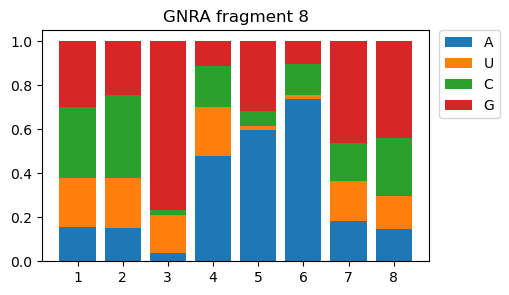

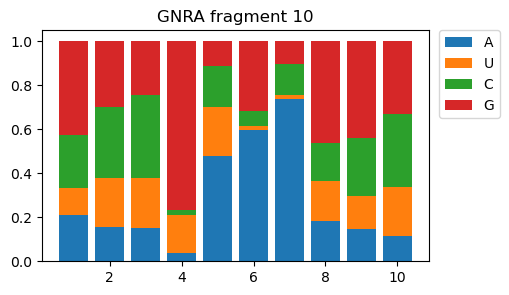

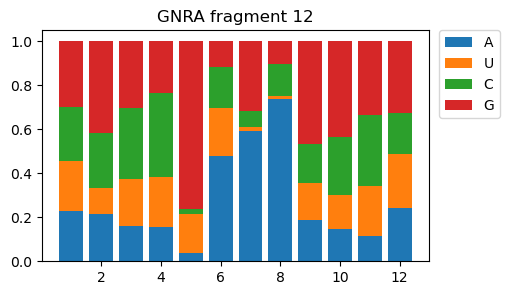

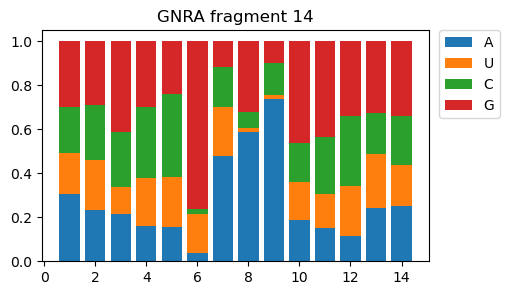

{0: {'A': 0.262, 'C': 0.235, 'G': 0.271, 'U': 0.232},
 1: {'A': 0.262, 'C': 0.235, 'G': 0.27, 'U': 0.234},
 2: {'A': 0.259, 'C': 0.237, 'G': 0.271, 'U': 0.233},
 3: {'A': 0.26, 'C': 0.238, 'G': 0.269, 'U': 0.232},
 4: {'A': 0.258, 'C': 0.238, 'G': 0.27, 'U': 0.235},
 5: {'A': 0.259, 'C': 0.238, 'G': 0.271, 'U': 0.232},
 6: {'A': 0.258, 'C': 0.236, 'G': 0.271, 'U': 0.235},
 7: {'A': 0.26, 'C': 0.236, 'G': 0.269, 'U': 0.235}}


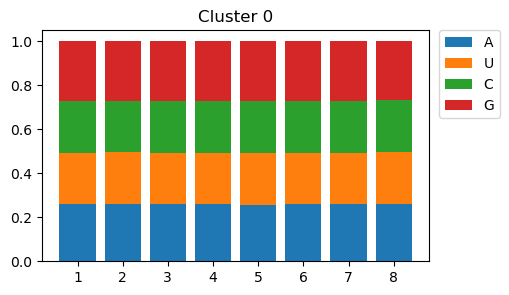

In [19]:
# Plot residue frequency figures

# Cluster groups, as named in Bottaro et al. Table SI1
gnra = [1]
gnra_like = [1, 3, 6, 9, 25, 26, 36, 40]
uncg = [2]
uncg_like = [2, 5, 37, 44]
u_turn = [4]

plot_res_freqs([i.res_seq for i in all_fragments_8 if i.clust_id in gnra_like], 'GNRA fragment 8')
plot_res_freqs([i.res_seq for i in all_fragments_10 if i.clust_id in gnra_like], 'GNRA fragment 10')
plot_res_freqs([i.res_seq for i in all_fragments_12 if i.clust_id in gnra_like], 'GNRA fragment 12')
plot_res_freqs([i.res_seq for i in all_fragments_14 if i.clust_id in gnra_like], 'GNRA fragment 14')

plot_res_freqs([i.res_seq for i in all_fragments_8 if i.clust_id == 0], 'Cluster 0', print_freqs=True)

In [20]:
# Tetraloop fragment dataset comparisons

print(f'Unique tetraloops: {len(tloop_seqs)}')
tloop_clust_nums = {clust: len([i for i in tloop_seqs if i.clust_id == clust]) for clust in range(1,45)}
print(tloop_clust_nums)

print(f'Unique aligned tetraloops: {len([i for i in all_fragments_8 if i.clust_id != 0])}')
aligned_tloop_clust_nums = {clust: len([i for i in all_fragments_8 if i.clust_id == clust]) for clust in range(1,45)}
print(aligned_tloop_clust_nums)

clust_num_diff = {i:tloop_clust_nums[i]-aligned_tloop_clust_nums[i] for i in range(1,45) if tloop_clust_nums[i] != aligned_tloop_clust_nums[i]}
print(f'Number of missing tetraloops: {clust_num_diff}')

Unique tetraloops: 332
{1: 153, 2: 24, 3: 7, 4: 10, 5: 4, 6: 11, 7: 3, 8: 7, 9: 1, 10: 8, 11: 13, 12: 7, 13: 6, 14: 8, 15: 2, 16: 1, 17: 1, 18: 3, 19: 5, 20: 5, 21: 8, 22: 1, 23: 1, 24: 3, 25: 11, 26: 1, 27: 1, 28: 2, 29: 2, 30: 6, 31: 3, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 2, 42: 1, 43: 1, 44: 1}


Unique aligned tetraloops: 329
{1: 152, 2: 24, 3: 7, 4: 10, 5: 4, 6: 11, 7: 3, 8: 7, 9: 1, 10: 8, 11: 13, 12: 7, 13: 6, 14: 8, 15: 2, 16: 1, 17: 1, 18: 3, 19: 5, 20: 5, 21: 8, 22: 1, 23: 1, 24: 3, 25: 11, 26: 1, 27: 1, 28: 2, 29: 1, 30: 6, 31: 3, 32: 1, 33: 1, 34: 1, 35: 1, 36: 0, 37: 1, 38: 1, 39: 1, 40: 1, 41: 2, 42: 1, 43: 1, 44: 1}
Number of missing tetraloops: {1: 1, 29: 1, 36: 1}


# Tetraloops
> The final tetraloop database is composed by 21,993 RNA fragments: 17,709 from X-ray, 3057 from NMR and 1227 from cryo-EM structures. The distributions of resolutions are shown in Fig. S1. [Bottaro et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5529312/)

According to Table SI1, there should be a total of 19383 tetraloops, which is supported by the number of files. I don't know where/what the remaining 2610 RNA fragments (from the total of 21993) are. The total number of "effective" tetraloops (members whose distance is above 0.07 eRMSD) is 16979. Parsing the tetraloop files returns 12027 unique (in terms of PDB ID and starting residue position) tetraloops. The size of each cluster is also supported by the number of files per folder.

In [21]:
clusters_dir = '../../../all_clusters'

all_tloop_files = [file for folder in os.listdir(clusters_dir) for file in os.listdir(f'{clusters_dir}/{folder}')]
print(f'Tetraloop files: {len(all_tloop_files)}')
tloop_seqs = utils.load('data/tloop_seqs.pickle')
print(f'Unique tetraloops: {len(tloop_seqs)}')

pdb_ids = sorted(list(set([i.pdb_id for i in tloop_seqs])))
print(f'PDB IDs: {pdb_ids}')

clust_size = {i:len([j for j in tloop_seqs if j.clust_id == i]) for i in range(1,45)}
print(f'Cluster size: {clust_size}')

Tetraloop files: 19383
Unique tetraloops: 332
PDB IDs: ['1a9l', '1bvj', '1c0o', '1esy', '1fka', '1hs1', '1hs4', '1hs8', '1ibk', '1jj2', '1k8a', '1ldz', '1m82', '1m90', '1msy', '1n66', '1nbs', '1nji', '1nyb', '1osw', '1q86', '1q93', '1q96', '1qwa', '1rfr', '1s9s', '1sm1', '1tob', '1txs', '1u6p', '1u9s', '1vq4', '1wz2', '1xwp', '1yi2', '1yj9', '1yjw', '1zdk', '1zih', '2aht', '2b2g', '2c50', '2c51', '2f87', '2gio', '2h0z', '2hgh', '2ihx', '2iz8', '2izn', '2jwv', '2k66', '2kxm', '2l1f', '2l3c', '2l3e', '2lhp', '2lps', '2lup', '2mqv', '2mtj', '2mxl', '2n1q', '2n3q', '2n6s', '2n7m', '2nc1', '2nz4', '2otl', '2p89', '2pcw', '2qex', '2tob', '2y9h', '2zjr', '2zm6', '2zzm', '3adb', '3bo4', '3bwp', '3cme', '3g8t', '3hl2', '3j6b', '3j79', '3j7a', '3j7o', '3j7p', '3j7y', '3j9m', '3jah', '3jbv', '3jce', '3jcs', '3ktw', '3owz', '3pdr', '3rg5', '3skt', '3zjt', '4a4s', '4aob', '4b5r', '4c7o', '4ena', '4fb0', '4io9', '4ioa', '4l81', '4lfb', '4lgt', '4lnt', '4lsk', '4lt8', '4lvv', '4m30', '4oog', '4p3e', 